In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d                                  #3D繪圖
from matplotlib.colors import ListedColormap                      #建立colormap，指定每個cluster要塗甚麼顏色
from sklearn.preprocessing import StandardScaler                  #把資料做標準化
from sklearn.model_selection import train_test_split              #用來把原始樣本拆成訓練資料與測試資料
from sklearn.metrics.pairwise import pairwise_distances_argmin    #找出距離最接近的資料的index

################################################################################################################################
#以下定義一些圖示化模型時所需的方法
################################################################################################################################

#此方法是假設第0類的資料中，距離其他類資料中心最遠的那一個資料
#也就是與其他資料中心的距離和為最大者，會被正確判斷
#然後我們把該資料與第0個資料互換位置
def Data_rearrangement_farthest(X,y,n_clusters):
    n_samples=len(list(X))
    n_features=len(list(X[0]))
    #初始化資料
    A=[]
    b=[]
    #A=X[0],b=y[0]
    #如果直接這樣設定，那麼後面指定X[0]=X[index]的時候，A的值也會跟著改變
    #所以這裡就把A裡面要儲存的數值換成是str，也就類似變成了不會改變的常數
    for column in range(n_features):
        A=A+[str(X[0,column])]
    b=b+[str(y[0])]
    #############################################################################
    #找出各類資料的中心(平均)(第0類除外)
    Xmean=np.array(X[0,:]).reshape(1,-1)  #資料初始化，而且資料形狀要調整
    for cluster in range(1,n_clusters):   #第0類資料不用算進去
        mean=X[0,:]                       #資料初始化
        for column in range(n_features):
            mean[column]=np.array(X[:,column][y==cluster]).mean()
        mean=np.array(mean).reshape(1,-1) #調整資料形狀
        Xmean=np.concatenate((Xmean,mean),axis=0)
    Xmean=np.array(Xmean[1:])             #第0列不要
    #############################################################################
    #找出第0類的每個資料與各資料中心的距離和
    Distance=[0 for index in range(n_samples)]
    for index in range(n_samples):
        if(y[index]==0):                         #只需要找第0類資料與其他中心的距離和
            Sum=0
            for cluster in range(1,n_clusters):  #其他的分類中心
                distance=0
                for column in range(n_features):
                    distance=distance+(X[index,column]-Xmean[cluster-1,column])**2
                Sum=Sum+np.sqrt(distance)
            Distance[index]=Sum
    Distance=np.array(Distance)
    #############################################################################
    #找出距離和最大的資料其相對應的index
    MAX=Distance.max()
    INDEX=-1
    for index in range(n_samples):
        if(Distance[index]==MAX):
            INDEX=index
            break
    #############################################################################
    #交換資料(第0個與第INDEX個交換)
    X[0]=X[INDEX]
    y[0]=y[INDEX]
    #把剛剛建立的常數資料轉換成浮點數資料，之後才能做計算
    for column in range(n_features):
        A[column]=float(A[column])
    b[0]=float(b[0])
    X[INDEX]=A                          #交換資料數值
    y[INDEX]=b[0]                       #交換資料數值
    return X,y,INDEX
################################################################################################################################
#此方法是假設第0類的資料中心會被正確判斷
#然後我們把該資料與第0個資料互換位置
def Data_rearrangement(X,y):
    n_features=len(list(X[0]))
    #初始化資料
    X0=X[y==0]
    X0center=[]
    A=[]
    b=[]
    #A=X[0],b=y[0]
    #如果直接這樣設定，那麼後面指定X[0]=X[index]的時候，A的值也會跟著改變
    #所以這裡就把A裡面要儲存的數值換成是str，也就類似變成了不會改變的常數
    for column in range(n_features):
        A=A+[str(X[0,column])]
    b=b+[str(y[0])]
    #找出第0類資料的中心(平均)
    for column in range(n_features):
        X0center=X0center+[np.array(X[:,column][y==0]).mean()]
    X0center=np.array(X0center).reshape(1,-1)      #重新調整形狀
    number=pairwise_distances_argmin(X0center,X0)  #這裡回傳的number是X[y==0]的index，並不是在原本X裡面的index
    index=pairwise_distances_argmin(X0[number],X)  #找出最接近中心的資料位置
    X[0]=X[index]                                  #改變資料數值
    y[0]=y[index]                                  #改變資料數值
    #把剛剛建立的常數資料轉換成浮點數資料，之後才能做計算
    for column in range(n_features):
        A[column]=float(A[column])
    b[0]=float(b[0])
    X[index]=A                                     #改變資料數值
    y[index]=b                                     #改變資料數值
    return X,y
################################################################################################################################
#這個函數會把分類標籤以遞增順序重新整理，而且相同的分類就會對應到相同的數字
#此方法是建立在第0個資料有正確判斷
#如果第0個資料是判斷錯誤的，那麼此方法也會跟著出錯
def Label_redesignation(y):
    n_samples=len(list(y))
    n_clusters=np.array(y).max()+1
    Y=[None for index in range(n_samples)]
    ##############################################
    #找出分類標準=0
    Y[0]=0 #第0個資料的分類數字定義為0
    for index in range(1,n_samples):
        if(y[index]==y[0]):
            Y[index]=0
    ##############################################
    #找出其他分類標準
    global Index                                 #宣告Index為全域變數
    used_label=[y[0]]                            #紀錄已使用過的label
    for label in range(1,n_clusters):            #0號分類已使用過
        for INDEX in range(1,n_samples):         #開頭的資料已使用過
            Index=-1                             #初始化Index
            if(y[INDEX] not in used_label):      #檢查y[index]是否為已使用過的label
                Index=INDEX                      #記錄當下的index
                used_label=used_label+[y[Index]] #記錄當下的實際label
                break
        for index in range(Index,n_samples):
            if(y[index]==y[Index]):
                Y[index]=label
    return np.array(Y)
################################################################################################################################
def Difference_coloring(Y,Y_predict,color_same,color_different):
    n_samples=len(list(Y))
    color_list=[]
    for index in range(n_samples):
        if((Y-Y_predict)[index]==0):
            color_list=color_list+[color_same]
        else:
            color_list=color_list+[color_different]
    return color_list
################################################################################################################################
def Accuracy(Y,Y_predict):
    n_samples=len(list(Y))
    difference=Y-Y_predict
    Fault=0
    for index in range(n_samples):
        if(difference[index]!=0):
            Fault=Fault+1
    accuracy=(n_samples-Fault)/n_samples
    return Fault,accuracy
################################################################################################################################
def Mislabel_searching(X,Y,Y_predict):
    n_samples=len(list(Y))
    difference=Y-Y_predict
    L=[]
    for index in range(n_samples):
        if(difference[index]!=0):
            L=L+[index]
    Mislabel=[[None for column in range(len(list(X[0])))] for row in range(len(L))]
    for row in range(len(L)):
        for column in range(len(list(X[0]))):
            Mislabel[row][column]=X[L[row],column]
    Mislabel=np.array(Mislabel)
    return Mislabel,L

Text(0.5, 1.0, 'Ideal')

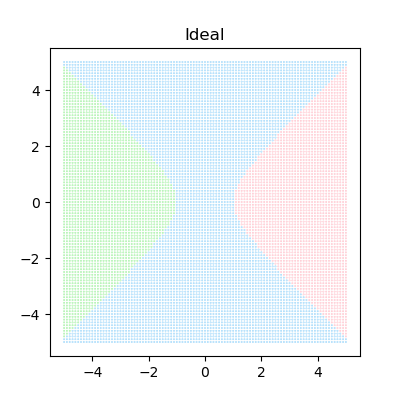

In [2]:
#做出理論範本
xrange=np.linspace(-5,5,101)
yrange=np.linspace(-5,5,101)
XX,YY=np.meshgrid(xrange,yrange)
background=np.array([XX.ravel(),YY.ravel()]).T
label=[]
for coordinate in background:
    if((coordinate[0]**2-coordinate[1]**2>1) and (coordinate[0]>0)):
        label+=[0]
    elif((coordinate[0]**2-coordinate[1]**2>1) and (coordinate[0]<0)):
        label+=[1]
    else:
        label+=[2]
label=np.array(label)
MyColor=ListedColormap(["lightpink", "lightgreen", "lightskyblue"])
fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.scatter(background[:,0],background[:,1],c=label,cmap=MyColor,s=0.1)
ax.set_title("Ideal")

In [6]:
#從裡面隨機挑選五千筆資料
random_pick=np.random.randint(low=0,high=background.shape[0],size=5000)
Xpick=background[random_pick]
ypick=label[random_pick]
#把資料分成訓練資料與測試資料
X_train,X_test,y_train,y_test=train_test_split(Xpick,ypick,test_size=0.2,random_state=0)

In [7]:
#建立模型
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
Models={
    "SGDC":SGDClassifier(loss="log_loss",alpha=1e-2,penalty="elasticnet",l1_ratio=0.5,learning_rate="invscaling",eta0=0.1,power_t=0.75,max_iter=10000),
    "DecisionTree":DecisionTreeClassifier(),
    "NaiveBayes":GaussianNB(),
    "linearSVC":SVC(kernel="linear"),
    "polySVC":SVC(kernel="poly",degree=5,C=100,coef0=10),
    "rbfSVC":SVC(kernel="rbf"),
    "sigmoidSVC":SVC(kernel="sigmoid",C=1e-2,gamma="scale"),
    "KNN":KNeighborsClassifier(n_neighbors=5)
}
#訓練模型並檢視訓練成果
scores={}
for name in Models:
    Models[name].fit(X_train,y_train)
    scores[(name,"train score")]=Models[name].score(X_train,y_train)
    scores[(name,"test score")]=Models[name].score(X_test,y_test)
Scores=pd.Series(scores).unstack()
print(Scores)
#以遞增順序來排列分類數字
X_test,y_test=Data_rearrangement(X_test,y_test)
y_test_relabelling=Label_redesignation(y_test)
y_test_labels={}
for name in Models:
    y_test_predict=Label_redesignation(Models[name].predict(X_test))
    y_test_labels[name]=y_test_predict

              test score  train score
DecisionTree       0.982      1.00000
KNN                0.991      0.99375
NaiveBayes         0.865      0.85350
SGDC               0.773      0.76925
linearSVC          0.768      0.77525
polySVC            1.000      1.00000
rbfSVC             0.988      0.98650
sigmoidSVC         0.668      0.66425


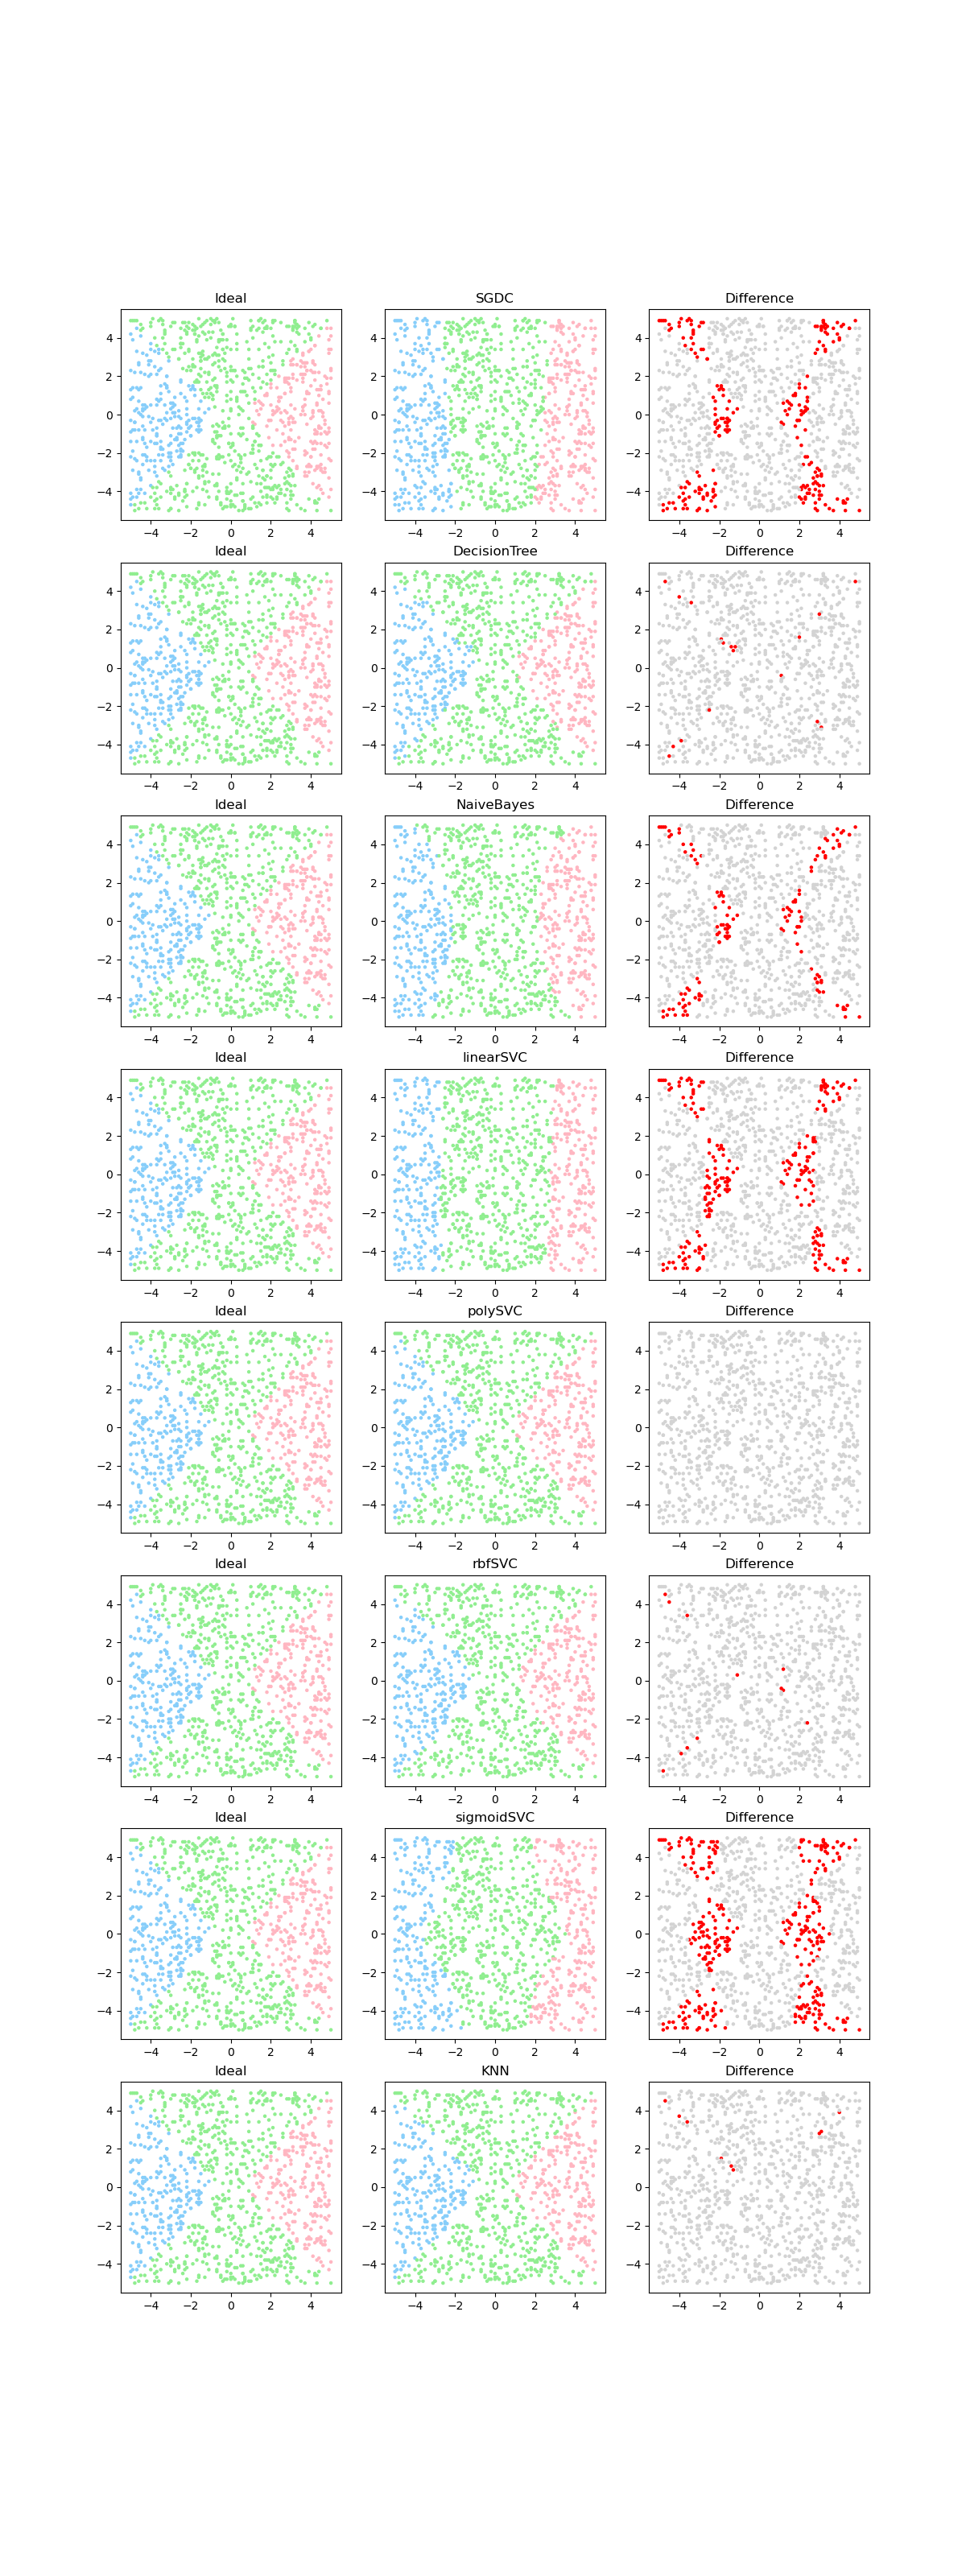

In [8]:
#預測結果圖示化
def NumToName(n):
    if(n==0):
        return "SGDC"
    elif(n==1):
        return "DecisionTree"
    elif(n==2):
        return "NaiveBayes"
    elif(n==3):
        return "linearSVC"
    elif(n==4):
        return "polySVC"
    elif(n==5):
        return "rbfSVC"
    elif(n==6):
        return "sigmoidSVC"
    else:
        return "KNN"
MyColor=ListedColormap(["lightpink","lightgreen","lightskyblue"])
fig,axs=plt.subplots(8,3,figsize=(12,32))
for i in range(24):
    if(i%3==0):
        axs[i//3][i%3].scatter(X_test[:,0],X_test[:,1],c=y_test_relabelling,cmap=MyColor,s=5)
        axs[i//3][i%3].set_title("Ideal")
    elif(i%3==1):
        axs[i//3][i%3].scatter(X_test[:,0],X_test[:,1],c=y_test_labels[NumToName(i//3)],cmap=MyColor,s=5)
        axs[i//3][i%3].set_title(NumToName(i//3))
    else:
        color_list=Difference_coloring(y_test_relabelling,y_test_labels[NumToName(i//3)],"lightgray","red")
        axs[i//3][i%3].scatter(X_test[:,0],X_test[:,1],c=color_list,s=5)
        axs[i//3][i%3].set_title("Difference")